In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import matplotlib.pyplot as plt
import seaborn as sns

from keplergl import KeplerGl
from shapely.geometry import Point
from fiona.crs import from_epsg
from datetime import datetime, timedelta
from pyproj import CRS

In [2]:
main_dataframe = pd.read_csv(r".\data\Adlie penguins, Sphenisciforms, foraging activity during chick-rearing period in Adlie Land.csv")
main_dataframe.head(3)

,event-id,visible,timestamp,location-long,location-lat,comments,migration-stage,tag-tech-spec,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name
0,17170065284,True,2010-12-21 06:34:09.000,139.688217,-65.636230,2010-2011,Chick-rearing,CatTrack,gps,NaN,2011_66_2,2011_66_2,"Adélie penguins, Sphenisciforms, foraging acti..."
1,17170083516,True,2010-12-21 06:34:09.000,139.688217,-65.636230,2010-2011,Chick-rearing,CatTrack,gps,NaN,2011_66_2,2011_66_2,"Adélie penguins, Sphenisciforms, foraging acti..."
2,17170065285,True,2010-12-21 06:44:23.000,140.004654,-66.663101,2010-2011,Chick-rearing,CatTrack,gps,NaN,2011_66_2,2011_66_2,"Adélie penguins, Sphenisciforms, foraging acti..."


In [3]:
drop_cols = ['event-id', 'visible', 'migration-stage', 
                'tag-tech-spec', 'sensor-type', 'individual-taxon-canonical-name',
                    'tag-local-identifier', 'study-name']
main_df = main_dataframe.drop(drop_cols, axis=1)
main_df = main_df.rename(columns={'location-long': 'longtitude', 'location-lat': 'latitude', 
                                      'individual-local-identifier': 'penguin_id'})
main_df.head(3)

,timestamp,longtitude,latitude,comments,penguin_id
0,2010-12-21 06:34:09.000,139.688217,-65.636230,2010-2011,2011_66_2
1,2010-12-21 06:34:09.000,139.688217,-65.636230,2010-2011,2011_66_2
2,2010-12-21 06:44:23.000,140.004654,-66.663101,2010-2011,2011_66_2


In [4]:
main_df = main_df.drop(main_df[main_df.longtitude.isnull()].index)
main_df.isnull().sum()

timestamp     0
longtitude    0
latitude      0
comments      0
penguin_id    0
dtype: int64

In [5]:
%%time
def point(row):
    x = float(row['longtitude'])
    y = float(row['latitude'])
    geometry_point = Point(x, y)
    return geometry_point

Wall time: 0 ns


KeplerGL

In [6]:
%%time
main_df['geometry'] = main_df.apply(point, axis=1)
geo_dataframe = gpd.GeoDataFrame(main_df, crs=from_epsg(4326))
geo_dataframe.head(3)

F:\Main\Anaconda\envs\geodata\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Wall time: 12.6 s


,timestamp,longtitude,latitude,comments,penguin_id,geometry
0,2010-12-21 06:34:09.000,139.688217,-65.636230,2010-2011,2011_66_2,POINT (139.68822 -65.63623)
1,2010-12-21 06:34:09.000,139.688217,-65.636230,2010-2011,2011_66_2,POINT (139.68822 -65.63623)
2,2010-12-21 06:44:23.000,140.004654,-66.663101,2010-2011,2011_66_2,POINT (140.00465 -66.66310)


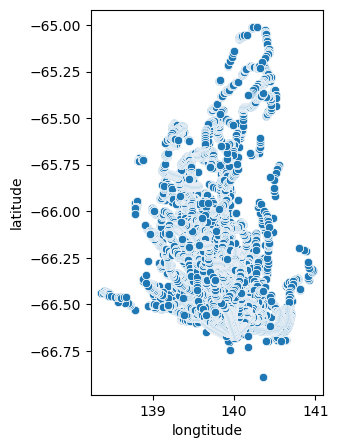

In [7]:
fig = plt.figure(figsize=(3, 5))
ax = fig.add_subplot(111)
sns.scatterplot(x=geo_dataframe.longtitude, y=geo_dataframe.latitude)
plt.show()

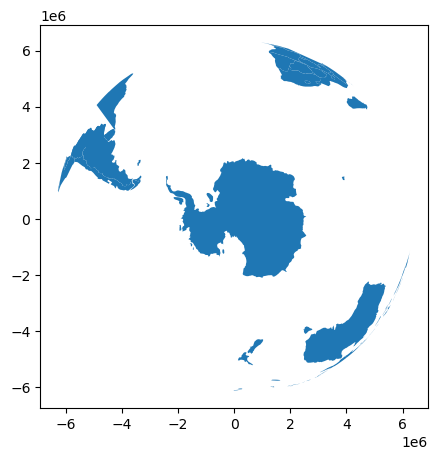

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
latitude = -90
longtitude = 0 
orthograph = CRS.from_proj4("+proj=ortho +lat_0={} +lon_0={} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs".format(latitude, longtitude))
world = world.to_crs(orthograph)
world.plot(figsize=(5, 5))
plt.show()

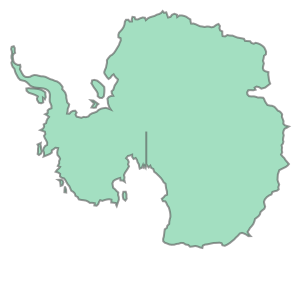

In [9]:
antarctic = list(world.loc[world.continent == 'Antarctica'].geometry)[0]
antarctic

In [10]:
geo_dataframe['time'] = pd.to_datetime(geo_dataframe.timestamp)
geo_dataframe = geo_dataframe.set_index('time')
geo_dataframe['year'] = geo_dataframe.index.year
geo_dataframe = geo_dataframe.reset_index(drop=True)

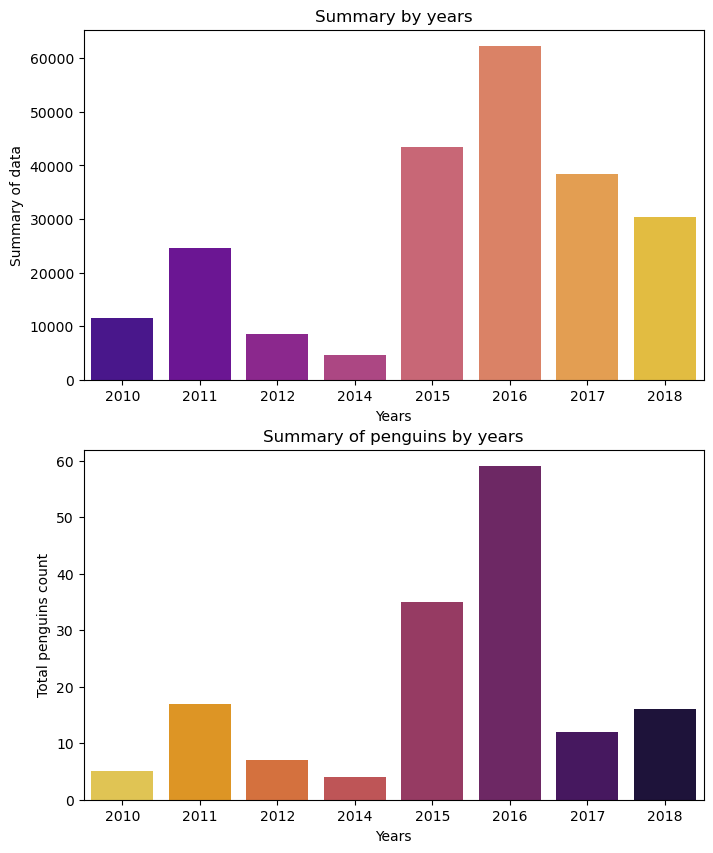

Wall time: 427 ms


In [11]:
%%time
years_label = geo_dataframe.year.unique()
years_label.sort()
values_count = []
penguin_count = []
for year in years_label:
    temp = geo_dataframe[geo_dataframe.year == year]
    values_count.append(temp.count()[0])
    penguin_count.append(len(temp.penguin_id.unique()))

fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(211)
sns.barplot(x=years_label, y=values_count, palette='plasma')
ax1.set_title('Summary by years')
ax1.set_ylabel('Summary of data')
ax1.set_xlabel('Years')
ax2 = fig.add_subplot(212)
ax2.set_title('Summary of penguins by years')
sns.barplot(x=years_label, y=penguin_count, palette='inferno_r')
ax2.set_ylabel('Total penguins count')
ax2.set_xlabel('Years')
plt.show()

In [12]:
year_subset = 2016
geo_df_2016 = geo_dataframe[geo_dataframe.year==year_subset]
geo_df_2016.head(3)

,timestamp,longtitude,latitude,comments,penguin_id,geometry,year
65546,2016-01-07 03:44:57.000,140.004440,-66.663330,2015-2016,2016_A1b,POINT (140.00444 -66.66333),2016
65547,2016-01-07 03:48:01.000,140.004395,-66.663315,2015-2016,2016_A1b,POINT (140.00439 -66.66331),2016
65548,2016-01-07 03:51:07.000,140.004440,-66.663322,2015-2016,2016_A1b,POINT (140.00444 -66.66332),2016


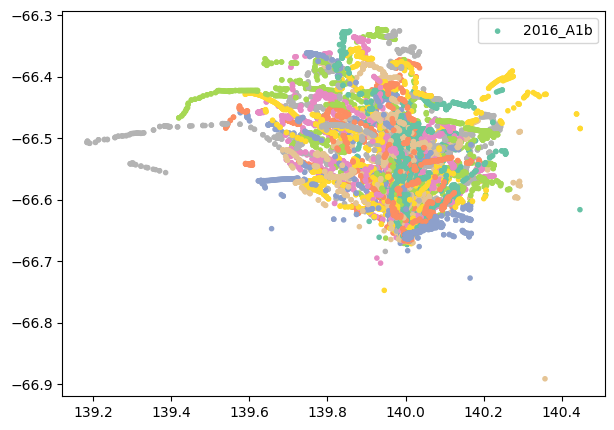

In [13]:
penguins = geo_df_2016.penguin_id.unique()
rgb_values = sns.color_palette("Set2", len(penguins))
color_map = dict(zip(penguins, rgb_values))

# Finally use the mapped values
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(geo_df_2016.longtitude, geo_df_2016.latitude, c=geo_df_2016.penguin_id.map(color_map), marker='.')
ax.legend(labels=penguins.tolist())
plt.show()

In [14]:
trajectory_collection = mpd.TrajectoryCollection(geo_df_2016, 'penguin_id')

In [15]:
def line_tracement(trajectories):
    tracement = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
    tracement['penguin_id'] = [route.id for route in trajectories]
    tracement['index'] = tracement['penguin_id']
    tracement = tracement.set_index('index')
    
    for line in trajectories:
        tracement.at[line.id, 'geometry'] = line.to_linestring()
        tracement.at[line.id, 'length_km'] = line.get_length() / 1000
        
    return tracement

In [16]:
penguin_lines = line_tracement(trajectory_collection)
penguin_lines.head(3)

,geometry,penguin_id,length_km
index,,,
2016_A1b,"LINESTRING (140.00444 -66.66333, 140.00439 -66...",2016_A1b,153.282152
2016_A2b,"LINESTRING (140.00534 -66.65986, 140.00447 -66...",2016_A2b,168.614557
2016_B1b,"LINESTRING (139.99722 -66.66299, 139.98204 -66...",2016_B1b,131.569450


In [17]:
keplergl = KeplerGl()
keplergl.add_data(penguin_lines, 'Pengiuns 2016')
keplergl.add_data(geo_df_2016, 'Penguins locations')
keplergl.save_to_html()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to keplergl_map.html!
